In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
print(type(mnist))
print(mnist.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


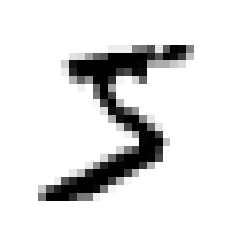

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X.iloc[0]
some_digit = np.array(some_digit)
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training binary classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Perfomance Measures

## Implementing custom cross validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)
print(skfolds)

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)


In [12]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


## Using default cross validation


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

## Evaluating the correctness with confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall trade-off

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv=3, method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [24]:
def plot_precision_revall_vs_thresholds(precisions, recalls,
                                        thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

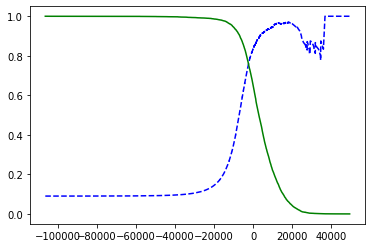

In [25]:
plot_precision_revall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

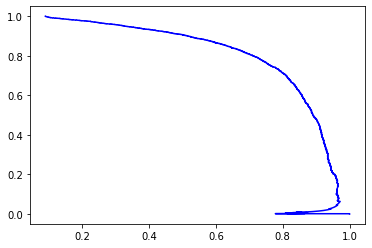

In [26]:
plt.plot(precisions, recalls, "b-")
plt.set_x_axis_label = "Precisions" 
plt.show()

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [28]:
y_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_pred_90)

0.4799852425751706

## The ROC curve (receiver operating characteristic)

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

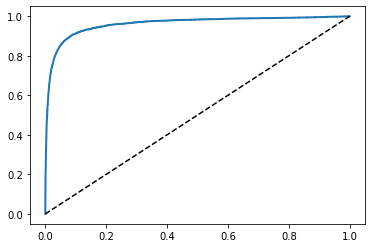

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.show()
    
plot_roc_curve(fpr, tpr, label="ROC curve")

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# Builing an RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                    cv=3, method="predict_proba")
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [35]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [37]:
forest_clf.fit(X_train, y_train_5)

RandomForestClassifier(random_state=42)

In [38]:
y_forest_predicted = forest_clf.predict(X_test)

In [40]:
y_forest_predicted

array([False, False, False, ..., False,  True, False])

In [41]:
y_test_5

60000    False
60001    False
60002    False
60003    False
60004    False
         ...  
69995    False
69996    False
69997    False
69998     True
69999    False
Name: class, Length: 10000, dtype: bool

In [42]:
precision_score(y_forest_predicted, y_test_5)

0.8677130044843049

In [43]:
recall_score(y_forest_predicted, y_test_5)

0.993581514762516

# Multiclass classification

In [45]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [51]:
some_digit_scores = svm_clf.dicision_function([some_digit])
some_digit_scores

AttributeError: 'SVC' object has no attribute 'dicision_function'

In [48]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [49]:
ovr_clf.predict([some_digit])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature nam

array([5], dtype=uint8)

In [50]:
len(ovr_clf.estimators_)

10

In [52]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [53]:
sgd_clf.predict([some_digit])
sgd_clf.decision_function([some_digit])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler.= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = accuracy)

# Error analysis

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

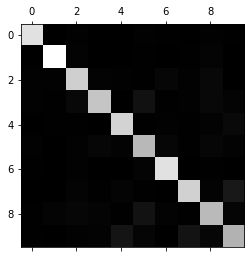

In [59]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [61]:
norm_conf_mx = conf_mx / row_sums

In [62]:
np.fill_diagonal(norm_conf_mx, 0)

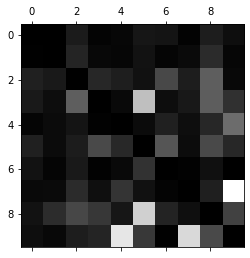

In [63]:
plt.matshow(norm_conf_mx, cmap="gray")

# Multilabel Classification

In [66]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [67]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [68]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [69]:
knn_clf.predict([some_digit])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [70]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

In [79]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

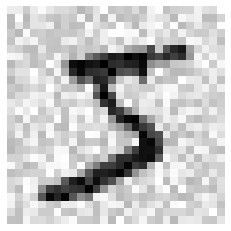

In [80]:
some_noised_digit = X_train_mod.iloc[0]
some_noised_digit = np.array(some_noised_digit)
some_noised_digit_image = some_noised_digit.reshape(28, 28)

plt.imshow(some_noised_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [82]:
knn_clf.fit(X_train_mod, y_train_mod)

NameError: name 'some_index' is not defined